# BAF627 HW1

20249433 최재필

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import scipy.optimize as sco

from tqdm import tqdm

In [2]:
np.random.seed(42)

In [3]:
CWD = Path.cwd()
OUTPUT_PATH = CWD / 'output'

## 0. Import Data

### Load data & convert

In [4]:
msf = pd.read_csv('msf.csv')
msp500_rf = pd.read_csv('msp500_risk_free.csv')

In [5]:
# datetime index
msf['mdate'] = pd.to_datetime(msf['mdate'])
msp500_rf['mdate'] = pd.to_datetime(msp500_rf['mdate'])

In [6]:
msf_ret_df = msf[['mdate', 'ticker', 'ret']].pivot(index='mdate', columns='ticker', values='ret')
sp500_ret_s = msp500_rf[['mdate', 'spret']].set_index('mdate')
rf_s = msp500_rf[['mdate', 'rf']].set_index('mdate')

sp500_excess_s = sp500_ret_s['spret'] - rf_s['rf']
msf_excess_df = msf_ret_df.subtract(rf_s['rf'], axis=0)

### Basic matrix/vectors

In [7]:
# Pandas
cov_df = msf_ret_df.cov()
excess_cov_df = msf_excess_df.cov()
mean_ret_s = msf_ret_df.mean()
mean_excess_s = msf_excess_df.mean()
std_s = msf_ret_df.std()

# Numpy
cov_2d = cov_df.values
excess_cov_2d = excess_cov_df.values
mean_ret_v = mean_ret_s.values
mean_excess_v = mean_excess_s.values
std_v = std_s.values

sp500_ret_v = sp500_ret_s.values
sp500_excess_v = sp500_excess_s.values
rf_v = rf_s.values

In [8]:
sid_list = mean_ret_s.index
date_list = msf_ret_df.index

### Basic scalar

In [9]:
mean_ret = mean_ret_v.mean()
mean_excess = mean_excess_v.mean()

sp500_ret = sp500_ret_v.mean()
sp500_std = sp500_ret_v.std()
sp500_excess = sp500_excess_v.mean()
sp500_excess_std = sp500_excess_v.std()

rf = rf_v.mean()

## 1. No risk-free & Short-selling allowed

Case #2

### (a)

- Derive the mean-variance frontier using the standard deviation for measuring risk
- Plot the mean-variance frontier
- Indicate the global minimum portfolio (GMVP) on the plot

In [10]:
def get_port_mean(W, mean_v, rf_v=None):
    if rf_v:
        return np.dot(W, mean_v - rf_v)
    else:
        return np.dot(W, mean_v)

In [11]:
def get_port_var(W, cov_2d):
    return np.dot(W.T, np.dot(cov_2d, W))

In [12]:
def negative_port_sharpe(W, mean_v, cov_2d, rf_v=None):
    port_mean = get_port_mean(W, mean_v, rf_v)
    port_var = get_port_var(W, cov_2d)
    port_std = np.sqrt(port_var)

    if port_mean > 0:
        return -port_mean / port_std
    else:
        return port_mean / port_std

In [13]:
def optimize_portfolio(mean_v, cov_2d):
    n = len(mean_v)
    args = (mean_v, cov_2d)
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
        ]
    bounds = tuple((-1, 1) for i in range(n))

    result = sco.minimize(
        negative_port_sharpe,
        n * [1. / n,],
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )

    return result

In [14]:
def optimize_portfolio_given_return(target_return, mean_v, cov_2d, rf_v=None):
    n = len(mean_v)
    args = (mean_v, cov_2d, rf_v)
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
        {'type': 'eq', 'fun': lambda W: target_return - get_port_mean(W, mean_v, rf_v)},
        ]
    bounds = tuple((-1, 1) for i in range(n))

    result = sco.minimize(
        negative_port_sharpe,
        n * [1. / n,],
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )

    return result

In [15]:
def get_efficient_frontier(mean_v, cov_2d, rf_v=None, return_minmax=[-0.1, 0.1], num_portfolios=100):
    weights_record = []

    min_return, max_return = return_minmax
    ret_range = np.linspace(min_return, max_return, num_portfolios)
    frontier_ports = np.zeros((3, len(ret_range))) # mean, std, sharpe

    for i, target_return in enumerate(tqdm(ret_range)):
        result = optimize_portfolio_given_return(target_return, mean_v, cov_2d, rf_v)
        weights = result.x

        port_mean = get_port_mean(weights, mean_v, rf_v)
        port_std = np.sqrt(get_port_var(weights, cov_2d))

        frontier_ports[0, i] = port_mean
        frontier_ports[1, i] = port_std
        frontier_ports[2, i] = port_mean / port_std

        weights_record.append(weights)

    return frontier_ports, weights_record

In [16]:
Q1_frontier_ports, Q1_weights_record = get_efficient_frontier(mean_ret_v, cov_2d, num_portfolios=100)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


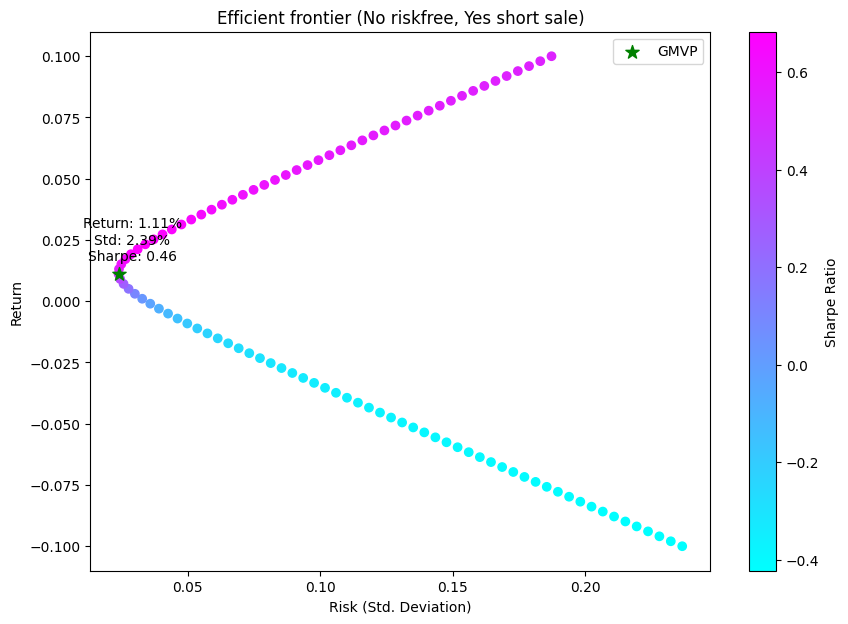

In [17]:
# Global minimum variance portfolio
min_vol_idx = np.argmin(Q1_frontier_ports[1])
gmvp_ret, gmvp_std, gmvp_sharpe = Q1_frontier_ports[:, min_vol_idx]

# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(Q1_frontier_ports[1, :], Q1_frontier_ports[0, :], c=Q1_frontier_ports[2, :], cmap='cool', marker='o')
plt.colorbar(label='Sharpe Ratio')

plt.scatter(gmvp_std, gmvp_ret, marker='*', color='g', s=100, label='GMVP')

plt.title('Efficient frontier (No riskfree, Yes short sale)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)

plt.annotate(
    f'Return: {gmvp_ret:.2%}\nStd: {gmvp_std:.2%}\nSharpe: {gmvp_sharpe:.2f}',
    (gmvp_std, gmvp_ret),
    textcoords='offset points',
    xytext=(10, 10),
    ha='center'
)

plt.show()

### (b)

- Derive optimal portfolio weights that matches S&P500 BM return
- Report portfolio weights in an excel file
- Report portfolio weights on a given set of stocks

In [18]:
sp500_ret

0.007691879732135416

In [19]:
Q1_match_sp500_result = optimize_portfolio_given_return(sp500_ret, mean_ret_v, cov_2d)
Q1_match_sp500_weights = Q1_match_sp500_result.x

Q1_match_sp500_weights_df = pd.DataFrame(Q1_match_sp500_weights, index=sid_list, columns=['weight'])
Q1_match_sp500_weights_df

,weight
ticker,
AAPL,-0.001531
ABT,0.033021
ADBE,-0.011211
ADI,-0.006286
ADP,-0.000268
...,...
VZ,-0.019541
WFC,-0.047710
WM,0.004380


In [20]:
Q1_match_sp500_weights_df.to_csv(OUTPUT_PATH / 'hw1_1.b_match_sp500_weights.csv')

In [21]:
WATCH_LIST = ['MMM', 'BAC', 'AMD', 'AAPL', 'MCD']

Q1_match_sp500_weights_df.loc[WATCH_LIST]

,weight
ticker,
MMM,0.137152
BAC,-0.017789
AMD,-0.024176
AAPL,-0.001531
MCD,-0.003986


### (c)

- Compute the annualized excess returns, annualized volatility, and annualized Sharpe ratio of the optimal (matching) portfolio and S&P500 BM

In [22]:
sp500_excess_annual = sp500_excess * 12
sp500_excess_std_annual = sp500_excess_std * np.sqrt(12)
sp500_sharpe = sp500_excess_annual / sp500_excess_std_annual

sp500_excess_annual, sp500_excess_std_annual, sp500_sharpe

(0.06700255678562506, 0.14584236192180058, 0.45941766097803083)

In [23]:
Q1_optimal_ret_s = msf_ret_df.multiply(Q1_match_sp500_weights, axis=1).sum(axis=1)
Q1_optimal_excess_s = Q1_optimal_ret_s - rf_s['rf']

Q1_optimal_excess = Q1_optimal_excess_s.mean()
Q1_optimal_excess_std = Q1_optimal_excess_s.std()

Q1_optimal_excess_annual = Q1_optimal_excess * 12
Q1_optimal_excess_std_annual = Q1_optimal_excess_std * np.sqrt(12)
Q1_optimal_sharpe = Q1_optimal_excess_annual / Q1_optimal_excess_std_annual

Q1_optimal_excess_annual, Q1_optimal_excess_std_annual, Q1_optimal_sharpe

(0.06700255678551453, 0.08799755612671221, 0.7614138361869288)

### (d)

- Plot the cumulative return of optimal and S&P500
- Discuss the difference in the performance of the two

In [24]:
def get_cumreturn(ret_s, cum_method='sum'):
    if cum_method == 'sum':
        return ret_s.cumsum()
    elif cum_method == 'prod':
        return (1 + ret_s).cumprod() - 1

In [25]:
sp500_cumret_s = get_cumreturn(sp500_ret_s)
Q1_optimal_cumret_s = get_cumreturn(Q1_optimal_ret_s)

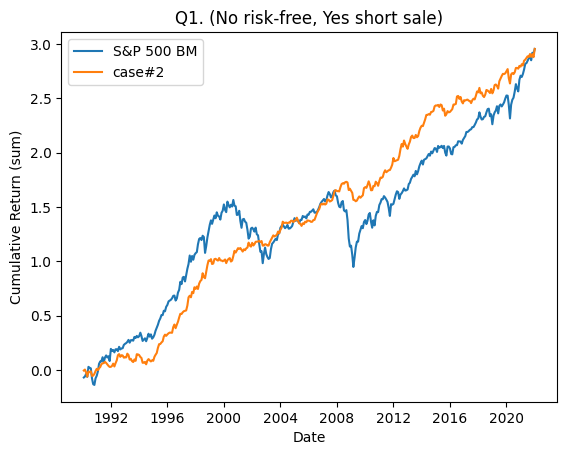

In [26]:
# Plot S&P 500 cumulative return
plt.plot(sp500_cumret_s, label='S&P 500 BM')

# Plot optimal matching portfolio cumulative return
plt.plot(Q1_optimal_cumret_s, label='case#2')

# Add title and labels
plt.title('Q1. (No risk-free, Yes short sale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (sum)')

# Add legend
plt.legend()

# Show plot
plt.show()

## 2. Yes risk-free & Yes Short-selling

Case #1

### (a)

- Derive the MV frontier
- Report the slop of the MV frontier
- Plot the MV frontier together with the MV frontier in Q1

In [27]:
Q2_tangent_point = (None, None) # std, ret
tangent_point_index = None
Q2_tangent_weight = None

current_maximum_sharpe = -np.inf
for i in range(Q1_frontier_ports.shape[1]): # From lowest to the highest return
    ret = Q1_frontier_ports[0, i]
    std = Q1_frontier_ports[1, i]
    
    current_sharpe = (ret - rf) / std
    if current_sharpe > current_maximum_sharpe:
        current_maximum_sharpe = current_sharpe
        Q2_tangent_point = (std, ret)
        Q2_tangent_weight = Q1_weights_record[i]
    
    if current_sharpe < current_maximum_sharpe:
        break

In [28]:
Q2_tangent_sharpe = current_maximum_sharpe
Q2_tangent_sharpe # Slope

0.6226493118422776

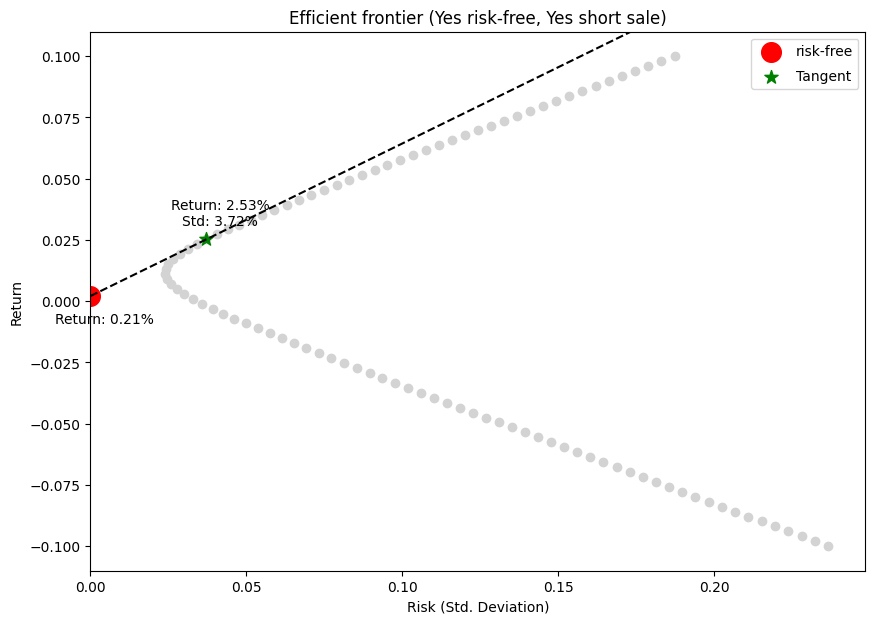

In [29]:
# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(Q1_frontier_ports[1, :], Q1_frontier_ports[0, :], c='#D3D3D3', marker='o')
# plt.colorbar(label='Sharpe Ratio')

# Plot risk-free point
plt.scatter(0, rf, marker='o', color='r', s=200, label='risk-free')

# Plot tangent point
plt.scatter(*Q2_tangent_point, marker='*', color='g', s=100, label='Tangent')

# Draw the Capital Market Line (CML)
plt.axline(
    (0, rf), 
    slope=(Q2_tangent_point[1] - rf) / Q2_tangent_point[0], 
    color='black', 
    linestyle='--', 
    linewidth=1.5,
)

# Add title and labels
plt.title('Efficient frontier (Yes risk-free, Yes short sale)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.xlim(left=0)

# Annotate risk-free point
plt.annotate(
    f'Return: {rf:.2%}',
    (0, rf),
    textcoords='offset points',
    xytext=(10, -20),  # Adjust position to avoid overlap
    ha='center'
)

# Annotate tangent point
plt.annotate(
    f'Return: {Q2_tangent_point[1]:.2%}\nStd: {Q2_tangent_point[0]:.2%}',
    Q2_tangent_point,
    textcoords='offset points',
    xytext=(10, 10),  # Adjust position to avoid overlap
    ha='center'
)

# Show plot
plt.show()


### (b)

- Derive optimal portfolio weights that matches S&P500 BM return
- Report portfolio weights in an excel file
- Report portfolio weights on a given set of stocks
- Report the weight of a risk-free asset

In [30]:
Q2_tangent_std, Q2_tangent_ret = Q2_tangent_point # 순서 조심. 
Q2_tangent_std, Q2_tangent_ret

(0.037170509111211766, 0.025252525252256443)

In [31]:
sp500_sharpe

0.45941766097803083

In [32]:
Q2_match_sp500_std = (sp500_ret - rf) / Q2_tangent_sharpe
Q2_match_sp500_std

0.008967401541457814

In [33]:
Q2_risky_weight = (sp500_ret - rf) / (Q2_tangent_ret - rf)
Q2_riskfree_weight = 1 - Q2_risky_weight

Q2_risky_weight, Q2_riskfree_weight

(0.2412504363238052, 0.7587495636761948)

In [34]:
Q2_port_weights = Q2_risky_weight * Q2_tangent_weight

Q2_port_weights_df = pd.DataFrame(Q2_port_weights, index=sid_list, columns=['weight'])
Q2_port_weights_df

,weight
ticker,
AAPL,0.010901
ABT,0.010874
ADBE,-0.002649
ADI,0.000142
ADP,-0.000255
...,...
VZ,-0.016808
WFC,0.018280
WM,0.007953


In [35]:
Q2_port_weights_df.to_csv(OUTPUT_PATH / 'hw1_2.b_port_weights.csv')

In [36]:
Q2_port_weights_df.loc[WATCH_LIST]

,weight
ticker,
MMM,0.023872
BAC,-0.008930
AMD,-0.002258
AAPL,0.010901
MCD,0.011199


### (c)

- Compute the annualized excess returns, annualized volatility, and annualized Sharpe ratio of the optimal (matching) portfolio and S&P500 BM
- Compare the result from Q1

In [37]:
Q2_optimal_ret_s = msf_ret_df.multiply(Q2_port_weights, axis=1).sum(axis=1)
Q2_optimal_ret = Q2_optimal_ret_s.mean()

Q2_riskfree_s = rf_s['rf'] * Q2_riskfree_weight

Q2_total_ret_s = Q2_optimal_ret_s + Q2_riskfree_s
Q2_total_excess_s = Q2_total_ret_s - rf_s['rf']

Q2_total_excess_std = Q2_total_excess_s.std()
Q2_total_excess_mean = Q2_total_excess_s.mean()

In [38]:
Q2_total_excess_mean_annual = Q2_total_excess_mean * 12
Q2_total_excess_std_annual = Q2_total_excess_std * np.sqrt(12)
Q2_total_sharpe = Q2_total_excess_mean_annual / Q2_total_excess_std_annual

Q2_total_excess_mean_annual, Q2_total_excess_std_annual, Q2_total_sharpe

(0.067002556785625, 0.031039753544505024, 2.1586046644847308)

In [39]:
# Results from Q1
Q1_optimal_excess_annual, Q1_optimal_excess_std_annual, Q1_optimal_sharpe

(0.06700255678551453, 0.08799755612671221, 0.7614138361869288)

In [40]:
# S&P 500 Benchmark
sp500_excess_annual, sp500_excess_std_annual, sp500_sharpe

(0.06700255678562506, 0.14584236192180058, 0.45941766097803083)

### (d)

- Plot the cumulative return of optimal and S&P500 (with previous results)
- Discuss the difference in the performance of the three portfolios

In [41]:
sp500_cumret_s = get_cumreturn(sp500_ret_s)
Q2_optimal_cumret_s = get_cumreturn(Q2_total_ret_s)

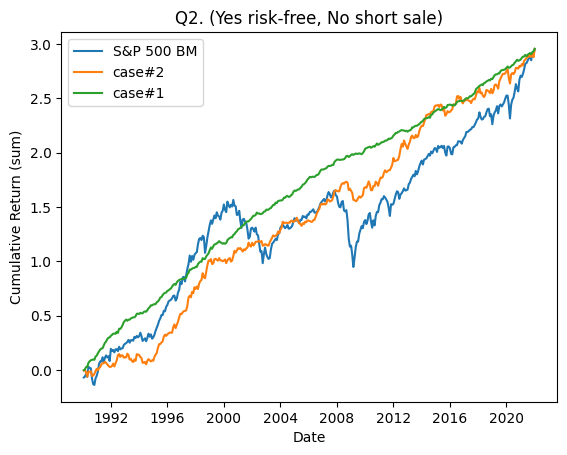

In [42]:
# Plot S&P 500 cumulative return
plt.plot(sp500_cumret_s, label='S&P 500 BM')

# Plot optimal matching portfolio cumulative return
plt.plot(Q1_optimal_cumret_s, label='case#2')
plt.plot(Q2_optimal_cumret_s, label='case#1')

# Add title and labels
plt.title('Q2. (Yes risk-free, No short sale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (sum)')

# Add legend
plt.legend()

# Show plot
plt.show()

## 3. Yes risk-free & Short-selling not allowed

Case #3

### (a)

- Derive the MV frontier
- Report the slop of the MV frontier
- Plot the MV frontier together with the MV frontier in Q1, Q2
- Report which one has a higher slope, and what its meaning is

In [43]:
def optimize_portfolio_given_return_noshort(target_return, mean_v, cov_2d, rf_v=None):
    n = len(mean_v)
    args = (mean_v, cov_2d, rf_v)
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
        {'type': 'eq', 'fun': lambda W: target_return - get_port_mean(W, mean_v, rf_v)},
        ]
    bounds = tuple((0, 1) for i in range(n))

    result = sco.minimize(
        negative_port_sharpe,
        n * [1. / n,],
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )

    return result

In [44]:
def get_efficient_frontier_noshort(mean_v, cov_2d, rf_v=None, return_minmax=[-0.1, 0.1], num_portfolios=100):
    weights_record = []

    min_return, max_return = return_minmax
    ret_range = np.linspace(min_return, max_return, num_portfolios)
    frontier_ports = np.zeros((3, len(ret_range))) # mean, std, sharpe

    for i, target_return in enumerate(tqdm(ret_range)):
        result = optimize_portfolio_given_return_noshort(target_return, mean_v, cov_2d, rf_v)
        weights = result.x

        port_mean = get_port_mean(weights, mean_v, rf_v)
        port_std = np.sqrt(get_port_var(weights, cov_2d))

        frontier_ports[0, i] = port_mean
        frontier_ports[1, i] = port_std
        frontier_ports[2, i] = port_mean / port_std

        weights_record.append(weights)

    return frontier_ports, weights_record

In [45]:
Q3_frontier_ports, Q3_weights_record = get_efficient_frontier_noshort(mean_ret_v, cov_2d, num_portfolios=100)

100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


In [46]:
Q3_tangent_point = (None, None) # std, ret
tangent_point_index = None
Q3_tangent_weight = None

current_maximum_sharpe = -np.inf
for i in range(Q3_frontier_ports.shape[1]): # From lowest to the highest return
    ret = Q3_frontier_ports[0, i]
    std = Q3_frontier_ports[1, i]
    
    current_sharpe = (ret - rf) / std

    if ret - rf < 0:
        continue

    if current_sharpe > current_maximum_sharpe:
        current_maximum_sharpe = current_sharpe
        Q3_tangent_point = (std, ret)
        Q3_tangent_weight = Q3_weights_record[i]


In [47]:
Q3_tangent_sharpe = current_maximum_sharpe
Q3_tangent_sharpe # Slope

0.41762878052139624

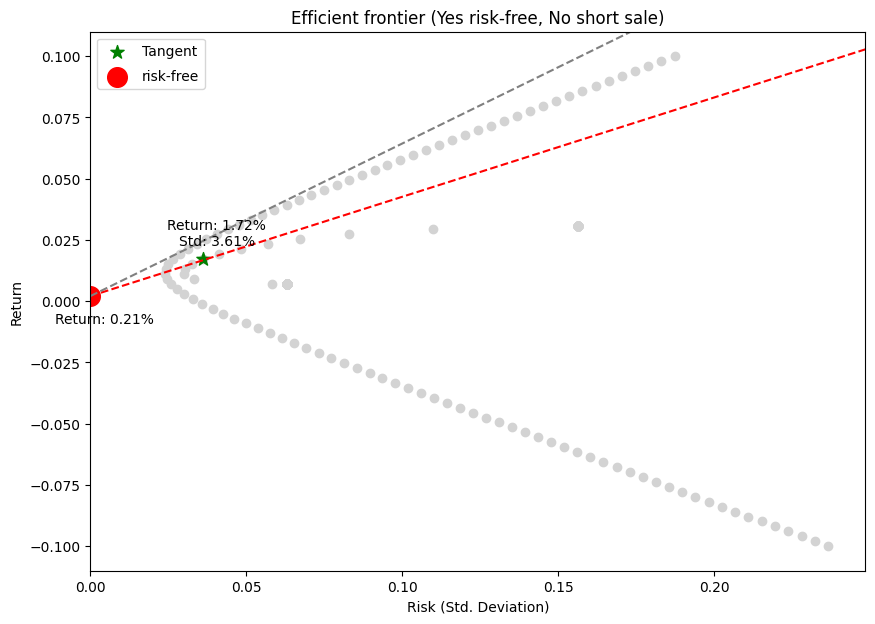

In [48]:
# Plot efficient frontier # Q3
plt.figure(figsize=(10, 7))
plt.scatter(Q3_frontier_ports[1, :], Q3_frontier_ports[0, :], c='#D3D3D3', marker='o')

plt.axline(
    (0, rf), 
    slope=(Q3_tangent_point[1] - rf) / Q2_tangent_point[0], 
    color='red', 
    linestyle='--', 
    linewidth=1.5,
)
# plt.colorbar(label='Sharpe Ratio')

# Plot efficient frontier # Q1
plt.scatter(Q1_frontier_ports[1, :], Q1_frontier_ports[0, :], color='#D3D3D3', marker='o')

# Draw the Capital Market Line (CML) # Q2
plt.axline(
    (0, rf), 
    slope=(Q2_tangent_point[1] - rf) / Q2_tangent_point[0], 
    color='gray', 
    linestyle='--', 
    linewidth=1.5,
)


# Plot tangent point
plt.scatter(*Q3_tangent_point, marker='*', color='g', s=100, label='Tangent')

# Plot risk-free point
plt.scatter(0, rf, marker='o', color='r', s=200, label='risk-free')

# Annotate risk-free point
plt.annotate(
    f'Return: {rf:.2%}',
    (0, rf),
    textcoords='offset points',
    xytext=(10, -20),  # Adjust position to avoid overlap
    ha='center'
)

# Annotate tangent point
plt.annotate(
    f'Return: {Q3_tangent_point[1]:.2%}\nStd: {Q3_tangent_point[0]:.2%}',
    Q3_tangent_point,
    textcoords='offset points',
    xytext=(10, 10),  # Adjust position to avoid overlap
    ha='center'
)

# Add title and labels
plt.title('Efficient frontier (Yes risk-free, No short sale)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.xlim(left=0)

# Show plot
plt.show()


As seen above, slope is much inferior in Q3 (red linear line, green star is the tangent point) compared to Q1 (gray parabolic curve) and Q2 (gray linear line)

This implys that yes-risk-free asset & no-short-sale constraint is making the efficient frontier worse, lowering the maximum utility for any investor. 

### (b)

- Derive optimal portfolio weights that matches S&P500 BM return
- Report portfolio weights in an excel file
- Report portfolio weights on a given set of stocks
- Report the weight of a risk-free asset

In [49]:
Q3_tangent_std, Q3_tangent_ret = Q3_tangent_point # 순서 조심. 
Q3_tangent_std, Q3_tangent_ret

(0.03606883562858762, 0.017171717171727066)

In [50]:
sp500_sharpe

0.45941766097803083

In [51]:
Q3_match_sp500_std = (sp500_ret - rf) / Q3_tangent_sharpe
Q3_match_sp500_std

0.013369639879299523

In [52]:
Q3_risky_weight = (sp500_ret - rf) / (Q3_tangent_ret - rf)
Q3_riskfree_weight = 1 - Q3_risky_weight

Q3_risky_weight, Q3_riskfree_weight

(0.3706701268921181, 0.6293298731078819)

In [53]:
Q3_port_weights = Q3_risky_weight * Q3_tangent_weight

Q3_port_weights_df = pd.DataFrame(Q3_port_weights, index=sid_list, columns=['weight'])
Q3_port_weights_df

,weight
ticker,
AAPL,1.314650e-02
ABT,1.129446e-02
ADBE,4.713676e-04
ADI,1.537233e-16
ADP,0.000000e+00
...,...
VZ,1.034698e-17
WFC,6.634902e-17
WM,9.659951e-03


In [54]:
Q3_port_weights_df.to_csv(OUTPUT_PATH / 'hw1_3.b_port_weights.csv')

In [55]:
Q3_port_weights_df.loc[WATCH_LIST]

,weight
ticker,
MMM,0.000000e+00
BAC,0.000000e+00
AMD,2.734723e-17
AAPL,1.314650e-02
MCD,0.000000e+00


### (c)

- Compute the annualized excess returns, annualized volatility, and annualized Sharpe ratio of the optimal (matching) portfolio and S&P500 BM
- Compare the result from Q1, Q2

In [56]:
Q3_optimal_ret_s = msf_ret_df.multiply(Q3_port_weights, axis=1).sum(axis=1)
Q3_optimal_ret = Q3_optimal_ret_s.mean()

Q3_riskfree_s = rf_s['rf'] * Q3_riskfree_weight

Q3_total_ret_s = Q3_optimal_ret_s + Q3_riskfree_s
Q3_total_excess_s = Q3_total_ret_s - rf_s['rf']

Q3_total_excess_std = Q3_total_excess_s.std()
Q3_total_excess_mean = Q3_total_excess_s.mean()

In [57]:
Q3_total_excess_mean_annual = Q3_total_excess_mean * 12
Q3_total_excess_std_annual = Q3_total_excess_std * np.sqrt(12)
Q3_total_sharpe = Q3_total_excess_mean_annual / Q3_total_excess_std_annual

Q3_total_excess_mean_annual, Q3_total_excess_std_annual, Q3_total_sharpe

(0.06700255678562501, 0.04619190144187771, 1.4505260596369456)

In [58]:
Q2_total_excess_mean_annual, Q2_total_excess_std_annual, Q2_total_sharpe

(0.067002556785625, 0.031039753544505024, 2.1586046644847308)

In [59]:
# Results from Q1
Q1_optimal_excess_annual, Q1_optimal_excess_std_annual, Q1_optimal_sharpe

(0.06700255678551453, 0.08799755612671221, 0.7614138361869288)

In [60]:
# S&P 500 Benchmark
sp500_excess_annual, sp500_excess_std_annual, sp500_sharpe

(0.06700255678562506, 0.14584236192180058, 0.45941766097803083)

### (d)

- Plot the cumulative return of optimal and S&P500 (with previous results)
- Discuss the difference in the performance of the four portfolios

In [61]:
Q3_optimal_cumret_s = get_cumreturn(Q3_total_ret_s)

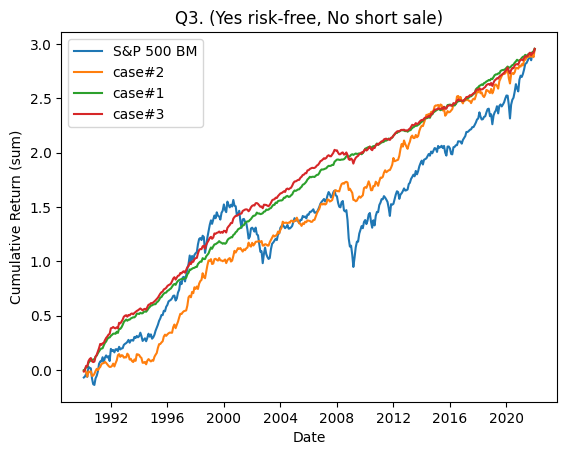

In [62]:
# Plot S&P 500 cumulative return
plt.plot(sp500_cumret_s, label='S&P 500 BM')

# Plot optimal matching portfolio cumulative return
plt.plot(Q1_optimal_cumret_s, label='case#2')
plt.plot(Q2_optimal_cumret_s, label='case#1')
plt.plot(Q3_optimal_cumret_s, label='case#3')

# Add title and labels
plt.title('Q3. (Yes risk-free, No short sale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (sum)')

# Add legend
plt.legend()

# Show plot
plt.show()

## 4. No risk-free & Short-selling not allowed

Case #4

### (a)

- Derive the MV frontier
- Report the slop of the MV frontier
- Plot the MV frontier together with the MV frontier in Q1, Q2, Q3
- Explain the differences in the plotted frontiers (Check the efficient frontier's shift)

In [63]:
Q4_tangent_point = (None, None) # std, ret
tangent_point_index = None
Q4_tangent_weight = None

current_maximum_sharpe = -np.inf
for i in range(Q3_frontier_ports.shape[1]): # From lowest to the highest return
    ret = Q3_frontier_ports[0, i]
    std = Q3_frontier_ports[1, i]
    
    current_sharpe = (ret - rf) / std

    if ret - rf < 0:
        continue

    if current_sharpe > current_maximum_sharpe:
        current_maximum_sharpe = current_sharpe
        Q4_tangent_point = (std, ret)
        Q4_tangent_weight = Q3_weights_record[i]


In [64]:
Q4_tangent_sharpe = current_maximum_sharpe
Q4_tangent_sharpe # Slope

0.41762878052139624

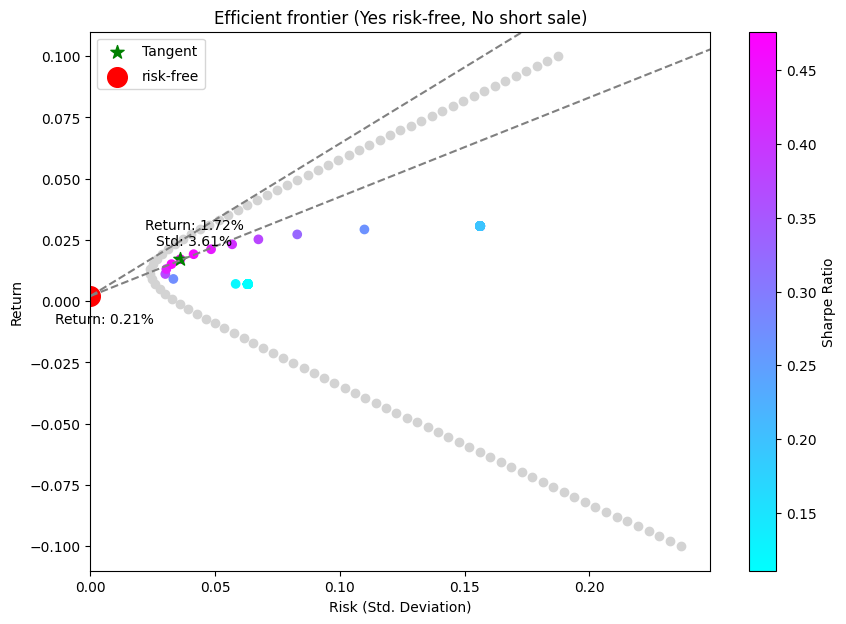

In [65]:
# Plot efficient frontier # Q3
plt.figure(figsize=(10, 7))
plt.scatter(Q3_frontier_ports[1, :], Q3_frontier_ports[0, :], c=Q3_frontier_ports[2, :], cmap='cool', marker='o')
plt.colorbar(label='Sharpe Ratio')

plt.axline(
    (0, rf), 
    slope=(Q3_tangent_point[1] - rf) / Q2_tangent_point[0], 
    color='gray', 
    linestyle='--', 
    linewidth=1.5,
)

# Plot efficient frontier # Q1
plt.scatter(Q1_frontier_ports[1, :], Q1_frontier_ports[0, :], color='#D3D3D3', marker='o')

# Draw the Capital Market Line (CML) # Q2
plt.axline(
    (0, rf), 
    slope=(Q2_tangent_point[1] - rf) / Q2_tangent_point[0], 
    color='gray', 
    linestyle='--', 
    linewidth=1.5,
)


# Plot tangent point
plt.scatter(*Q4_tangent_point, marker='*', color='g', s=100, label='Tangent')

# Plot risk-free point
plt.scatter(0, rf, marker='o', color='r', s=200, label='risk-free')

# Annotate risk-free point
plt.annotate(
    f'Return: {rf:.2%}',
    (0, rf),
    textcoords='offset points',
    xytext=(10, -20),  # Adjust position to avoid overlap
    ha='center'
)

# Annotate tangent point
plt.annotate(
    f'Return: {Q4_tangent_point[1]:.2%}\nStd: {Q4_tangent_point[0]:.2%}',
    Q4_tangent_point,
    textcoords='offset points',
    xytext=(10, 10),  # Adjust position to avoid overlap
    ha='center'
)

# Add title and labels
plt.title('Efficient frontier (Yes risk-free, No short sale)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.xlim(left=0)

# Show plot
plt.show()


As seen above, slope is much inferior in Q4 (colorful parabolic curve) compared to Q1 (gray parabolic curve), Q2 (gray linear line) and Q3 (gray linear line that's flatter)

This implys that no-risk-free asset & no-short-sale constraint is making the efficient frontier worse, lowering the maximum utility for any investor. 

### (b)

- Derive optimal portfolio weights that matches S&P500 BM return
- Report portfolio weights in an excel file
- Report portfolio weights on a given set of stocks
- Report the weight of a risk-free asset

In [66]:
Q4_match_sp500_result = optimize_portfolio_given_return_noshort(sp500_ret, mean_ret_v, cov_2d)
Q4_match_sp500_weights = Q4_match_sp500_result.x

Q4_match_sp500_weights_df = pd.DataFrame(Q4_match_sp500_weights, index=sid_list, columns=['weight'])
Q4_match_sp500_weights_df

,weight
ticker,
AAPL,5.928417e-17
ABT,0.000000e+00
ADBE,0.000000e+00
ADI,0.000000e+00
ADP,5.562268e-16
...,...
VZ,1.594855e-01
WFC,0.000000e+00
WM,2.020815e-16


In [67]:
Q4_match_sp500_weights_df.to_csv(OUTPUT_PATH / 'hw1_4.b_match_sp500_weights.csv')

In [68]:
WATCH_LIST = ['MMM', 'BAC', 'AMD', 'AAPL', 'MCD']

Q4_match_sp500_weights_df.loc[WATCH_LIST]

,weight
ticker,
MMM,9.688367e-18
BAC,6.145568e-17
AMD,0.000000e+00
AAPL,5.928417e-17
MCD,0.000000e+00


### (c)

- Compute the annualized excess returns, annualized volatility, and annualized Sharpe ratio of the optimal (matching) portfolio and S&P500 BM
- Compare the result from Q1, Q2, Q3

In [69]:
Q4_optimal_ret_s = msf_ret_df.multiply(Q4_match_sp500_weights, axis=1).sum(axis=1)
Q4_optimal_excess_s = Q4_optimal_ret_s - rf_s['rf']

Q4_optimal_excess = Q4_optimal_excess_s.mean()
Q4_optimal_excess_std = Q4_optimal_excess_s.std()

Q4_optimal_excess_annual = Q4_optimal_excess * 12
Q4_optimal_excess_std_annual = Q4_optimal_excess_std * np.sqrt(12)
Q4_optimal_sharpe = Q4_optimal_excess_annual / Q4_optimal_excess_std_annual

Q4_optimal_excess_annual, Q4_optimal_excess_std_annual, Q4_optimal_sharpe

(0.06700255678404274, 0.15315200468934148, 0.43749056318232926)

In [70]:
Q3_total_excess_mean_annual, Q3_total_excess_std_annual, Q3_total_sharpe

(0.06700255678562501, 0.04619190144187771, 1.4505260596369456)

In [71]:
Q2_total_excess_mean_annual, Q2_total_excess_std_annual, Q2_total_sharpe

(0.067002556785625, 0.031039753544505024, 2.1586046644847308)

In [72]:
# Results from Q1
Q1_optimal_excess_annual, Q1_optimal_excess_std_annual, Q1_optimal_sharpe

(0.06700255678551453, 0.08799755612671221, 0.7614138361869288)

In [73]:
# S&P 500 Benchmark
sp500_excess_annual, sp500_excess_std_annual, sp500_sharpe

(0.06700255678562506, 0.14584236192180058, 0.45941766097803083)

### (d)

- Plot the cumulative return of optimal and S&P500 (with previous results)
- Discuss the difference in the performance of the five portfolios

In [74]:
Q4_optimal_cumret_s = get_cumreturn(Q4_optimal_ret_s)

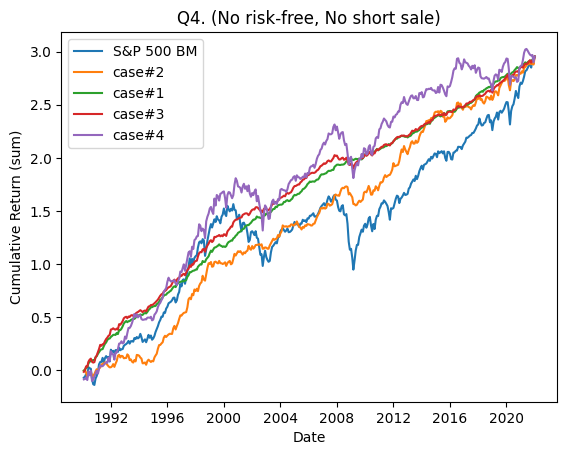

In [75]:
# Plot S&P 500 cumulative return
plt.plot(sp500_cumret_s, label='S&P 500 BM')

# Plot optimal matching portfolio cumulative return
plt.plot(Q1_optimal_cumret_s, label='case#2')
plt.plot(Q2_optimal_cumret_s, label='case#1')
plt.plot(Q3_optimal_cumret_s, label='case#3')
plt.plot(Q4_optimal_cumret_s, label='case#4')

# Add title and labels
plt.title('Q4. (No risk-free, No short sale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (sum)')

# Add legend
plt.legend()

# Show plot
plt.show()

## 5. Portfolio performance and the number of stocks

### (a) 

- Randomly choose 10 stocks
- Plot the MV frontier for case #2 (No risk-free, short-sale allowed)
- Plot the MV frontier for case #1 (Yes risk-free, short-sale allowed)
- Compare annualized Sharpe with case #2 and case #1

In [76]:
random_10_sid_list = np.random.choice(sid_list, 10, replace=False)
random_10_sid_list

array(['SO', 'LLY', 'NKE', 'IBM', 'HUM', 'FISV', 'CL', 'RTX', 'APD',
       'AAPL'], dtype=object)

In [77]:
random_msf_ret_df = msf_ret_df[random_10_sid_list].copy()
random_msf_excess_df = random_msf_ret_df.subtract(rf_s['rf'], axis=0)

# Pandas
random_cov_df = random_msf_ret_df.cov()
random_excess_cov_df = random_msf_excess_df.cov()
random_mean_ret_s = random_msf_ret_df.mean()
random_mean_excess_s = random_msf_excess_df.mean()
random_std_s = random_msf_ret_df.std()

# Numpy
random_cov_2d = random_cov_df.values
random_excess_cov_2d = random_excess_cov_df.values
random_mean_ret_v = random_mean_ret_s.values
random_mean_excess_v = random_mean_excess_s.values
random_std_v = random_std_s.values

random_sid_list = random_mean_ret_s.index

random_mean_ret = random_mean_ret_v.mean()
random_mean_excess = random_mean_excess_v.mean()

#### MV frontier for case #2 (No risk-free, Yes short-sale)

In [78]:
Q5a_frontier_ports, Q5a_weights_record = get_efficient_frontier(random_mean_ret_v, random_cov_2d, num_portfolios=100)

100%|██████████| 100/100 [00:00<00:00, 137.55it/s]


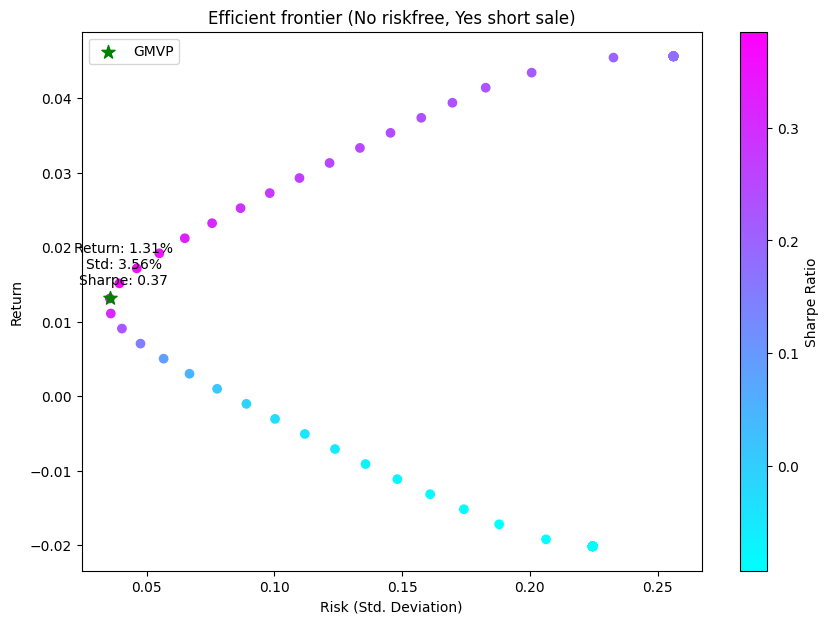

In [79]:
# Global minimum variance portfolio
min_vol_idx = np.argmin(Q5a_frontier_ports[1])
gmvp_ret, gmvp_std, gmvp_sharpe = Q5a_frontier_ports[:, min_vol_idx]

# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(Q5a_frontier_ports[1, :], Q5a_frontier_ports[0, :], c=Q5a_frontier_ports[2, :], cmap='cool', marker='o')
plt.colorbar(label='Sharpe Ratio')

plt.scatter(gmvp_std, gmvp_ret, marker='*', color='g', s=100, label='GMVP')

plt.title('Efficient frontier (No riskfree, Yes short sale)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)

plt.annotate(
    f'Return: {gmvp_ret:.2%}\nStd: {gmvp_std:.2%}\nSharpe: {gmvp_sharpe:.2f}',
    (gmvp_std, gmvp_ret),
    textcoords='offset points',
    xytext=(10, 10),
    ha='center'
)

plt.show()

#### MV frontier for case #1 (Yes risk-free, Yes short-sale)

In [80]:
Q5a_tangent_point = (None, None) # std, ret
tangent_point_index = None
Q5a_tangent_weight = None

current_maximum_sharpe = -np.inf
for i in range(Q5a_frontier_ports.shape[1]): # From lowest to the highest return
    ret = Q5a_frontier_ports[0, i]
    std = Q5a_frontier_ports[1, i]
    
    current_sharpe = (ret - rf) / std
    if current_sharpe > current_maximum_sharpe:
        current_maximum_sharpe = current_sharpe
        Q5a_tangent_point = (std, ret)
        Q5a_tangent_weight = Q5a_weights_record[i]

In [81]:
Q5_tangent_sharpe = current_maximum_sharpe
Q5_tangent_sharpe # Slope

0.33160460544982456

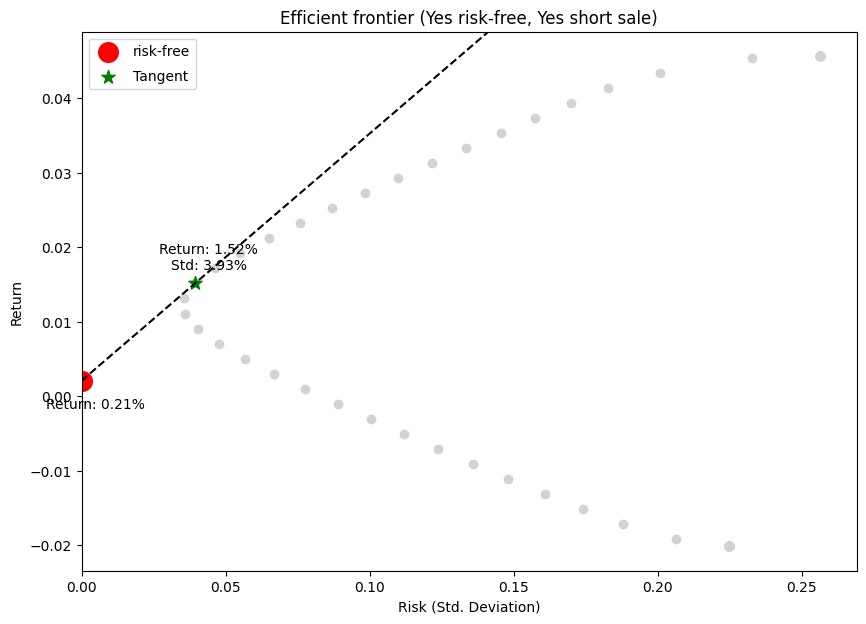

In [82]:
# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(Q5a_frontier_ports[1, :], Q5a_frontier_ports[0, :], c='#D3D3D3', marker='o')
# plt.colorbar(label='Sharpe Ratio')

# Plot risk-free point
plt.scatter(0, rf, marker='o', color='r', s=200, label='risk-free')

# Plot tangent point
plt.scatter(*Q5a_tangent_point, marker='*', color='g', s=100, label='Tangent')

# Draw the Capital Market Line (CML)
plt.axline(
    (0, rf), 
    slope=(Q5a_tangent_point[1] - rf) / Q5a_tangent_point[0], 
    color='black', 
    linestyle='--', 
    linewidth=1.5,
)

# Add title and labels
plt.title('Efficient frontier (Yes risk-free, Yes short sale)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.xlim(left=0)

# Annotate risk-free point
plt.annotate(
    f'Return: {rf:.2%}',
    (0, rf),
    textcoords='offset points',
    xytext=(10, -20),  # Adjust position to avoid overlap
    ha='center'
)

# Annotate tangent point
plt.annotate(
    f'Return: {Q5a_tangent_point[1]:.2%}\nStd: {Q5a_tangent_point[0]:.2%}',
    Q5a_tangent_point,
    textcoords='offset points',
    xytext=(10, 10),  # Adjust position to avoid overlap
    ha='center'
)

# Show plot
plt.show()


#### Annualized Sharpe of case #2 (No risk-free, Yes short-sale)

In [83]:
Q5a_match_sp500_result = optimize_portfolio_given_return(sp500_ret, random_mean_ret_v, random_cov_2d)
Q5a_match_sp500_weights = Q5a_match_sp500_result.x

In [84]:
Q5a_optimal_ret_s = random_msf_ret_df.multiply(Q5a_match_sp500_weights, axis=1).sum(axis=1)
Q5a_optimal_excess_s = Q5a_optimal_ret_s - rf_s['rf']

Q5a_optimal_excess = Q5a_optimal_excess_s.mean()
Q5a_optimal_excess_std = Q5a_optimal_excess_s.std()

Q5a_optimal_excess_annual = Q5a_optimal_excess * 12
Q5a_optimal_excess_std_annual = Q5a_optimal_excess_std * np.sqrt(12)
Q5a_optimal_sharpe = Q5a_optimal_excess_annual / Q5a_optimal_excess_std_annual

Q5a_optimal_excess_annual, Q5a_optimal_excess_std_annual, Q5a_optimal_sharpe

(0.06700255678502735, 0.15590950611729895, 0.42975286404036067)

#### Annualized Sharpe of case #1 (Yes risk-free, Yes short-sale)

In [85]:
Q5a_tangent_ret_s = random_msf_ret_df.multiply(Q5a_tangent_weight, axis=1).sum(axis=1)
Q5a_tangent_excess_s = Q5a_tangent_ret_s - rf_s['rf']

Q5a_tangent_excess = Q5a_tangent_excess_s.mean()
Q5a_tangent_excess_std = Q5a_tangent_excess_s.std()

Q5a_tangent_excess_annual = Q5a_tangent_excess * 12
Q5a_tangent_excess_std_annual = Q5a_tangent_excess_std * np.sqrt(12)
Q5a_tangent_sharpe = Q5a_tangent_excess_annual / Q5a_tangent_excess_std_annual

Q5a_tangent_excess_annual, Q5a_tangent_excess_std_annual, Q5a_tangent_sharpe

(0.1565181818175014, 0.1361590347354541, 1.1495247606712509)

### (b)

- Construct money-sector portfolio C (`flag_sector=1`)
- Construct diverse-industry portfolio D (`flag_sector=0`)
- Plot MV frontiers of C, D for case #2 (No risk-free, short-sale allowed)
- Plot MV frontiers of C, D for case #1 (Yes risk-free, short-sale allowed)
- Report whose Sharpe is higher and explain why
